## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [69]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import warnings
warnings.filterwarnings('ignore')

In [70]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv('../../../../my_env.env')

True

In [71]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [72]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Display sample data
df_ticker.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,55.43,55.45,54.98,54.99,4881442,30491,55.201737,NKE
2017-05-02 04:00:00+00:00,55.12,55.16,54.79,55.07,7363885,41589,54.967165,NKE
2017-05-03 04:00:00+00:00,55.17,55.30,54.40,54.53,9486619,48477,54.622933,NKE
2017-05-04 04:00:00+00:00,54.68,54.83,54.20,54.47,6830628,39260,54.501544,NKE
2017-05-05 04:00:00+00:00,54.41,54.50,53.56,53.95,13379949,57959,53.889567,NKE


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [73]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                        NKE                ...            \
                                vwap   open   high    low  ...    volume   
timestamp                                                  ...             
2017-05-01 04:00:00+00:00  39.278779  55.43  55.45  54.98  ...   4881442   
2017-05-02 04:00:00+00:00  38.996448  55.12  55.16  54.79  ...   7363885   
2017-05-03 04:00:00+00:00  38.423685  55.17  55.30  54.40  ...   9486619   
2017-05-04 04:00:00+00:00  37.965109  54.68  54.83  54.20  ...   6830628   
2017-05-05 04:00:00+00:00  38.424403  54.41  54.50  53.56  ...  13379949   

                                                    XOM                  \
                          trade_count       vwap   open     high    low   
timestamp                                                                 
2017-05-01 04:00:00+00:00       30491  55.201737  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00       41589  54.967165  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00       48477  54.622933  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00       39260  54.501544  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00       57959  53.889567  81.63  82.2350  81.61   

                                                                   
                           close    volume trade_count       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [74]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_dist = MCSimulation(
    portfolio_data=df_ticker,
    weights=[.33,.33,.33],
    num_simulation=1000,
    num_trading_days=252*5
)

# Print the simulation input data
MC_dist.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [75]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992368,1.017198,0.996462,1.002958,1.019590,1.005538,1.002479,0.980956,1.002263,1.006398,...,0.999092,1.017990,1.010478,1.013479,0.994188,0.989423,0.997686,0.992975,1.011857,0.997919
2,0.993634,1.019895,0.980081,1.000398,1.019121,1.006329,1.015086,0.975198,0.995927,0.993490,...,0.979148,1.028074,0.999825,1.002313,0.984886,0.993527,0.997235,0.983256,1.003883,1.009171
3,0.977271,1.002390,0.965299,0.984053,1.006812,1.009872,1.003838,0.969093,0.980796,0.997674,...,0.978759,1.028466,0.990272,1.006554,0.992378,0.998905,0.987786,0.984352,1.015680,1.016748
4,0.971183,1.009926,0.970708,0.978663,1.007781,1.017132,1.007050,0.971047,0.956599,0.984715,...,0.973430,1.044032,1.007852,1.000500,0.992636,0.984059,0.984375,0.979395,0.999874,1.013021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.475107,1.273035,1.629944,3.546695,1.052182,2.421950,1.897976,1.786730,2.217778,0.760096,...,1.553039,1.572281,0.988624,1.139432,1.249369,1.480758,1.317384,1.120595,1.942266,1.499153
1257,0.473140,1.266384,1.662307,3.580040,1.051194,2.404626,1.886337,1.812737,2.214751,0.770530,...,1.558910,1.556494,0.973073,1.128498,1.236717,1.505190,1.310285,1.125080,1.906588,1.495840
1258,0.472223,1.271103,1.665274,3.547932,1.038987,2.386968,1.883409,1.792899,2.205629,0.780268,...,1.551850,1.532960,0.953884,1.118194,1.243496,1.473498,1.337391,1.124621,1.932121,1.491427
1259,0.472011,1.293991,1.634179,3.519799,1.045143,2.370010,1.836813,1.774020,2.203720,0.784702,...,1.556278,1.540802,0.933523,1.110912,1.224984,1.485757,1.356379,1.112500,1.930150,1.503923


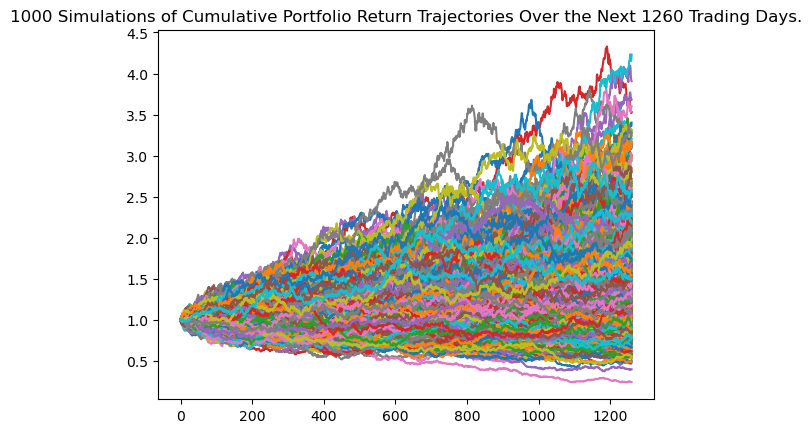

In [76]:
# Plot simulation outcomes
line_plot = MC_dist.plot_simulation()

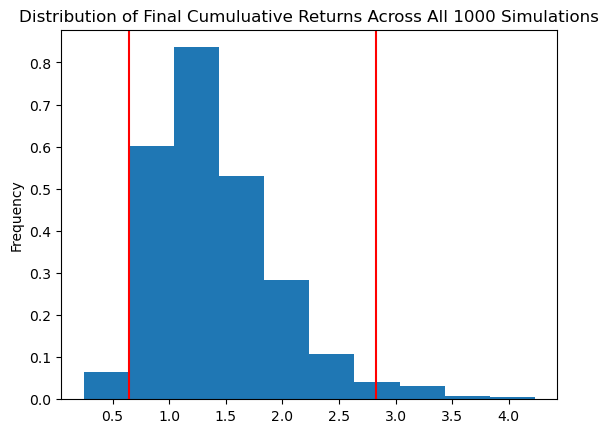

In [77]:
# Plot probability distribution and confidence intervals
dist_plot = MC_dist.plot_distribution()

In [78]:
# Fetch summary statistics from the Monte Carlo simulation results
even_table = MC_dist.summarize_cumulative_return()

# Print summary statistics
print(even_table)

count           1000.000000
mean               1.416103
std                0.554240
min                0.247276
25%                1.027120
50%                1.311606
75%                1.694887
max                4.230257
95% CI Lower       0.644506
95% CI Upper       2.828594
Name: 1260, dtype: float64


In [79]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
even_lower = round(even_table[8]*15000,2)
even_upper = round(even_table[9]*15000,2)

# Print results
print(f'There is 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end in the range of ${even_lower} and ${even_upper}')

There is 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end in the range of $9667.59 and $42428.9


### Simulate five year portfolio growth with 60% AT&T stock

In [80]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att = MCSimulation(
    portfolio_data=df_ticker,
    weights=[.6,.2,.2],
    num_simulation=1000,
    num_trading_days=252*5
)

# Print the simulation input data
MC_att.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [81]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995560,0.995170,1.014307,0.999510,0.993747,1.011083,1.008770,0.994973,1.017014,0.997101,...,0.998660,1.011192,0.999961,1.003881,0.998134,1.009756,1.005092,0.990711,0.993360,1.002295
2,1.002874,0.997742,1.045594,1.009364,1.000466,1.005412,1.018929,1.000627,1.017925,1.014840,...,1.005539,1.022739,1.002387,1.006214,0.993861,1.004781,1.030235,0.993254,1.007949,1.004389
3,1.002420,1.007993,1.060531,1.008045,0.998242,0.997776,1.015254,0.990263,1.007659,1.016738,...,1.003364,1.054090,0.984930,1.010419,1.001607,1.018175,1.029121,0.977586,1.004707,0.990146
4,0.990076,1.013231,1.071498,1.006350,0.985419,1.007148,1.008414,1.004127,1.028112,1.042440,...,1.003082,1.057452,0.977811,1.024924,1.002603,1.010492,1.030243,0.996057,1.014503,1.007315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.060251,0.649991,0.603948,1.744964,0.702742,1.655158,1.510730,1.672669,1.422936,0.744422,...,1.182880,0.896527,1.490000,1.144625,0.728500,0.723559,1.364229,1.883415,1.242114,1.290294
1257,1.045156,0.656326,0.602988,1.740024,0.704079,1.618477,1.528779,1.670375,1.420744,0.749881,...,1.177994,0.885639,1.502821,1.150727,0.715756,0.724145,1.365893,1.942367,1.221568,1.276456
1258,1.058781,0.646423,0.603203,1.750852,0.708994,1.632599,1.560706,1.666878,1.422886,0.736270,...,1.174817,0.880428,1.517143,1.142935,0.707654,0.716281,1.341174,1.922549,1.223055,1.290892
1259,1.051433,0.647467,0.608236,1.751785,0.719424,1.636186,1.561911,1.681218,1.430400,0.734538,...,1.165869,0.873259,1.500694,1.123253,0.697033,0.722051,1.340330,1.973099,1.212220,1.287423


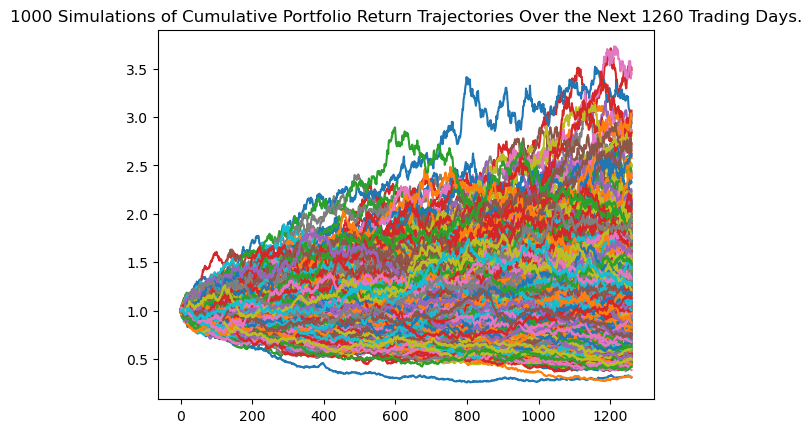

In [82]:
# Plot simulation outcomes
line_att_plot = MC_att.plot_simulation()

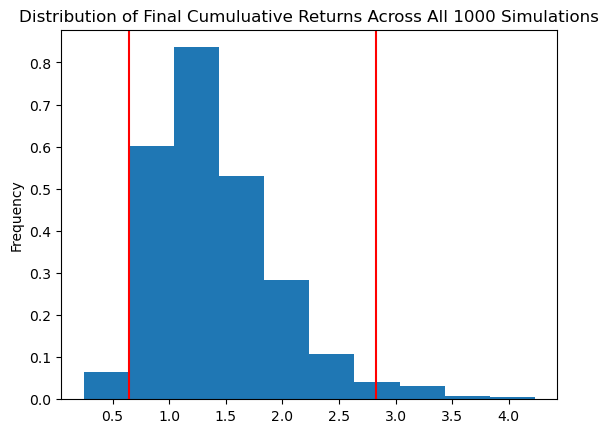

In [83]:
# Plot probability distribution and confidence intervals
dist_att_plot = MC_dist.plot_distribution()

In [84]:
# Fetch summary statistics from the Monte Carlo simulation results
even_att_table = MC_att.summarize_cumulative_return()

# Print summary statistics
print(even_att_table)

count           1000.000000
mean               1.156019
std                0.462566
min                0.310122
25%                0.827608
50%                1.073055
75%                1.398632
max                3.482324
95% CI Lower       0.514691
95% CI Upper       2.326645
Name: 1260, dtype: float64


In [85]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
even_att_lower = round(even_att_table[8]*15000,2)
even_att_upper = round(even_att_table[9]*15000,2)

# Print results
print(f'There is 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end in the range of ${even_att_lower} and ${even_att_upper}')

There is 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end in the range of $7720.37 and $34899.67


### Simulate five year portfolio growth with 60% Nike stock

In [86]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike = MCSimulation(
    portfolio_data=df_ticker,
    weights=[.2,.6,.2],
    num_simulation=1000,
    num_trading_days=252*5
)

# Printing the simulation input data
MC_nike.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [87]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.017171,0.992950,1.003321,0.991263,1.003796,1.010636,1.004630,1.008574,1.007517,0.998340,...,0.988700,1.012934,0.996672,1.006954,0.998655,1.001758,1.006816,1.025308,1.002215,0.988328
2,1.028114,0.998219,0.994820,0.988240,0.985786,1.015389,1.009377,1.014429,0.984806,1.006850,...,0.996586,1.017173,0.998366,0.982426,0.977252,1.028827,1.012103,1.039140,1.000195,0.991725
3,1.052850,0.988038,1.011382,0.983095,1.009156,1.009769,1.016675,1.011130,0.989883,1.016355,...,1.002613,1.022463,1.008771,0.980473,0.968908,1.026427,1.006955,1.046293,0.984313,0.990710
4,1.062369,0.989441,1.016257,0.975303,1.001493,1.024524,1.023716,1.029263,0.972300,1.027450,...,1.022283,1.010291,0.994624,0.991845,0.981819,1.038041,1.008175,1.057833,0.980575,0.997156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.019422,1.415829,2.279901,2.781188,1.878953,3.553995,1.092946,0.728972,2.809650,3.003422,...,3.536798,5.004669,2.310736,2.408970,3.624765,1.789576,1.725426,2.881267,1.470464,2.213740
1257,2.014342,1.414889,2.230723,2.781517,1.890151,3.499204,1.110330,0.728669,2.856956,3.026548,...,3.582061,5.041030,2.320664,2.399927,3.581047,1.810396,1.753902,2.846391,1.465188,2.196626
1258,2.020628,1.441773,2.258559,2.835518,1.883183,3.520531,1.105890,0.734193,2.726855,3.000673,...,3.594857,4.987239,2.295602,2.381443,3.570408,1.768121,1.745018,2.855320,1.460247,2.215267
1259,2.036376,1.441527,2.316366,2.823851,1.920724,3.520849,1.107302,0.740182,2.709523,3.031070,...,3.542555,4.934876,2.294576,2.348185,3.526197,1.766020,1.740993,2.820552,1.476927,2.193132


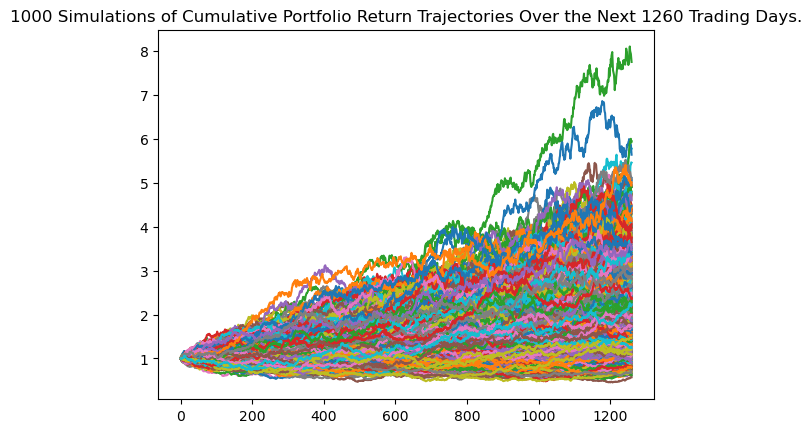

In [88]:
# Plot simulation outcomes
line_nike_plot = MC_nike.plot_simulation()

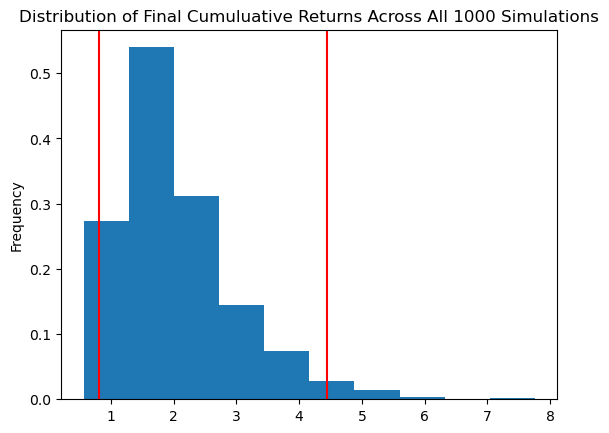

In [89]:
# Plot probability distribution and confidence intervals
dist_nike_plot = MC_nike.plot_distribution()

In [90]:
# Fetch summary statistics from the Monte Carlo simulation results
even_nike_table = MC_nike.summarize_cumulative_return()

# Print summary statistics
print(even_nike_table)

count           1000.000000
mean               2.046193
std                0.933167
min                0.569029
25%                1.402754
50%                1.831822
75%                2.522962
max                7.757597
95% CI Lower       0.811088
95% CI Upper       4.445056
Name: 1260, dtype: float64


In [91]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
even_nike_lower = round(even_nike_table[8]*15000,2)
even_nike_upper = round(even_nike_table[9]*15000,2)

# Print results
print(f'There is 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end in the range of ${even_nike_lower} and ${even_nike_upper}')

There is 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end in the range of $12166.33 and $66675.84


### Simulate five year portfolio growth with 60% Exxon stock

In [92]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_exxon = MCSimulation(
    portfolio_data=df_ticker,
    weights=[.2,.2,.6],
    num_simulation=1000,
    num_trading_days=252*5
)

# Printing the simulation input data
MC_exxon.portfolio_data

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   
...                          ...    ...    ...    ...       ...         ...   
2021-04-26 04:00:00+00:00  31.38  31.38  30.89  30.91  45360916      135223   
2021-04-27 04:00:00+00:00  30.84  30.88  30.63  30.77  33200088      123035   
2021-04-28 04:00:00+00:00  30.97  31.15  30.90  30.96  27960327      105456   
2021-04-29 04:00:00+00:00  31.12  31.53  31.11  31.34  37758789      129297   
2021-04-30 04:00:00+00:00  31.36  31.43  31.05  31.41  31132760      103024   

                                                      NKE          ...  \
                                vwap daily_return    open    high  ...   
timestamp                                                          ...   
2017-05-01 04:00:00+00:00  39.278779          NaN   55.43   55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836   55.12   55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121   55.17   55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156   54.68   54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470   54.41   54.50  ...   
...                              ...          ...     ...     ...  ...   
2021-04-26 04:00:00+00:00  31.027616    -0.015605  130.49  131.70  ...   
2021-04-27 04:00:00+00:00  30.742178    -0.004529  132.00  132.79  ...   
2021-04-28 04:00:00+00:00  31.009157     0.006175  132.27  132.29  ...   
2021-04-29 04:00:00+00:00  31.320009     0.012274  131.77  134.12  ...   
2021-04-30 04:00:00+00:00  31.287630     0.002234  132.44  133.88  ...   

                                                      XOM                  \
                                 vwap daily_return   open     high    low   
timestamp                                                                   
2017-05-01 04:00:00+00:00   55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00   54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00   54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00   54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00   53.889567    -0.009547  81.63  82.2350  81.61   
...                               ...          ...    ...      ...    ...   
2021-04-26 04:00:00+00:00  130.887296     0.010830  55.62  56.2850  55.44   
2021-04-27 04:00:00+00:00  132.160411     0.003875  56.01  56.6300  55.81   
2021-04-28 04:00:00+00:00  130.802962    -0.010597  56.88  58.4600  56.79   
2021-04-29 04:00:00+00:00  132.969621     0.019509  58.92  59.4800  58.15   
2021-04-30 04:00:00+00:00  132.817825    -0.004803  58.33  58.8900  57.16   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  
...                          ...       ...         ...        ...          ...  
2021-04-26 04:00:00+00:00  55.68  16034091       92919  55.853625     0.001979 

In [93]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_exxon.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001400,1.011533,0.999226,1.009482,0.981615,1.002959,1.013916,1.007064,0.999330,1.004045,...,0.985540,1.029860,1.001298,1.006371,1.013966,0.994227,0.992172,0.993884,1.003391,0.982089
2,1.026555,1.031347,0.992560,1.016324,0.995081,1.018563,1.022709,1.015590,1.009465,1.034588,...,1.008269,1.053711,1.016510,1.008038,1.029842,0.996768,0.994853,0.995451,0.993772,0.982224
3,1.033266,1.030191,0.988650,1.015713,0.996305,1.019067,1.012039,1.022665,1.003036,1.058166,...,1.026354,1.039584,1.011852,1.002449,1.033400,0.994212,1.004053,1.005178,1.007756,0.991975
4,1.040643,1.045707,1.011197,1.035913,0.990044,1.032812,1.020440,1.021095,0.999892,1.055528,...,1.027554,1.041881,1.007339,1.005667,1.045556,1.005877,0.995378,1.000783,0.996468,1.012625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.875849,1.372126,0.753812,3.597828,0.372727,0.718007,1.365250,0.715015,1.410053,1.421650,...,1.091541,1.456631,1.797748,0.740248,2.327105,0.442461,0.819598,0.474086,1.377894,1.778169
1257,1.928326,1.406908,0.763893,3.634324,0.365295,0.728010,1.390904,0.712881,1.428639,1.438349,...,1.087424,1.487262,1.778054,0.739791,2.331963,0.437985,0.814986,0.468071,1.375545,1.812955
1258,1.930074,1.434131,0.762620,3.594537,0.362188,0.719642,1.417541,0.715526,1.425114,1.447087,...,1.068083,1.489871,1.783657,0.736228,2.331730,0.437719,0.810523,0.466661,1.339928,1.824152
1259,1.933199,1.416961,0.754739,3.570288,0.371651,0.722177,1.409857,0.730972,1.446187,1.440861,...,1.060371,1.495613,1.792477,0.745222,2.305025,0.442328,0.801734,0.458278,1.367164,1.805999


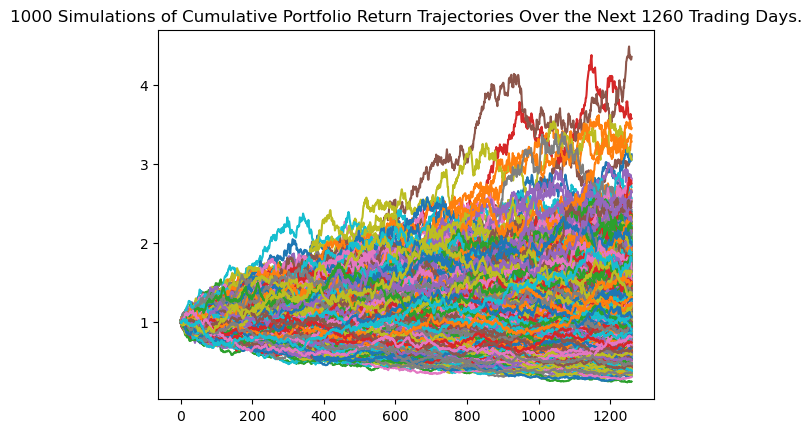

In [94]:
# Plot simulation outcomes
line_xom_plot = MC_exxon.plot_simulation()

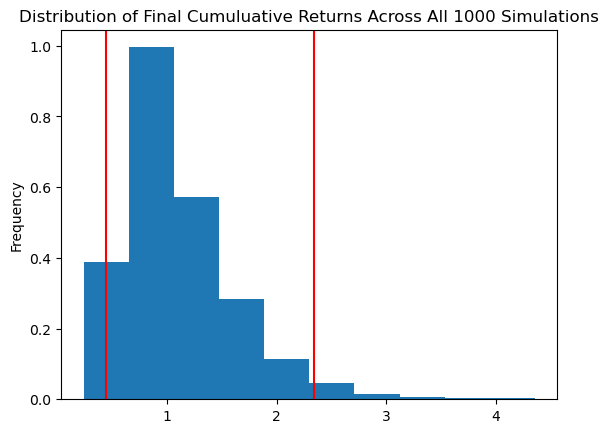

In [95]:
# Plot probability distribution and confidence intervals
dist_xom_plot = MC_exxon.plot_distribution()

In [96]:
# Fetch summary statistics from the Monte Carlo simulation results
even_xom_table = MC_exxon.summarize_cumulative_return()

# Print summary statistics
print(even_xom_table)

count           1000.000000
mean               1.105518
std                0.512030
min                0.240812
25%                0.751673
50%                0.989423
75%                1.360052
max                4.358168
95% CI Lower       0.438149
95% CI Upper       2.345917
Name: 1260, dtype: float64


In [97]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
even_xom_lower = round(even_xom_table[8]*15000,2)
even_xom_upper = round(even_xom_table[9]*15000,2)

# Print results
print(f'There is 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end in the range of ${even_xom_lower} and ${even_xom_upper}')

There is 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end in the range of $6572.24 and $35188.76


### Summarize findings across all 4 simulations

YOUR ANSWER HERE!